# Hypothesis 2: Reviewer Type vs. Efficiency

This notebook analyzes how the type of reviewer (Bot, User, or Both) affects the efficiency of AI-generated Pull Requests (PRs). Efficiency is measured by the PR lifecycle (time to decision) and the number of iteration cycles.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Set plot style
sns.set_theme(style="whitegrid")

## 1. Load Data
We load the necessary datasets from Hugging Face: `pr_df`, `pr_timeline_df`, and `pr_reviews_df`.

In [2]:
print("Loading datasets...")
try:
    all_pr_df = pd.read_parquet("hf://datasets/hao-li/AIDev/all_pull_request.parquet")
    all_repo_df = pd.read_parquet("hf://datasets/hao-li/AIDev/all_repository.parquet")
    all_user_df = pd.read_parquet("hf://datasets/hao-li/AIDev/all_user.parquet")

    # Basic
    pr_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pull_request.parquet")
    repo_df = pd.read_parquet("hf://datasets/hao-li/AIDev/repository.parquet")
    user_df = pd.read_parquet("hf://datasets/hao-li/AIDev/user.parquet")
    
    # Comments and reviews
    pr_comments_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_comments.parquet")
    pr_reviews_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_reviews.parquet")
    pr_review_comments_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_review_comments_v2.parquet")
    
    # Commits
    pr_commits_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_commits.parquet")
    pr_commit_details_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_commit_details.parquet")
    
    # Related issues
    related_issue_df = pd.read_parquet("hf://datasets/hao-li/AIDev/related_issue.parquet")
    issue_df = pd.read_parquet("hf://datasets/hao-li/AIDev/issue.parquet")
    
    # Events
    pr_timeline_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_timeline.parquet")
    
    # Task type
    pr_task_type_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_task_type.parquet")
    
    # Human-PR
    human_pr_df = pd.read_parquet("hf://datasets/hao-li/AIDev/human_pull_request.parquet")
    human_pr_task_type_df = pd.read_parquet("hf://datasets/hao-li/AIDev/human_pr_task_type.parquet")

    print("Datasets loaded successfully.")
except Exception as e:
    print(f"Error loading datasets: {e}")
    pr_df, pr_timeline_df, pr_reviews_df = None, None, None

Loading datasets...


C:\Users\preet\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Datasets loaded successfully.


## 2. Preprocess PR Data
We filter for closed PRs and calculate the lifecycle in hours.

In [11]:
if pr_df is not None:
    print("Preprocessing PR data...")
    # Filter for closed PRs
    closed_prs = pr_df[pr_df["state"] == "closed"].copy()
    
    # Convert timestamps to datetime
    closed_prs["created_at"] = pd.to_datetime(closed_prs["created_at"])
    closed_prs["closed_at"] = pd.to_datetime(closed_prs["closed_at"])
    
    # Calculate lifecycle in hours
    closed_prs["lifecycle_hours"] = (closed_prs["closed_at"] - closed_prs["created_at"]).dt.total_seconds() / 3600
    
    pr_lifecycle = closed_prs[["id", "state", "lifecycle_hours"]]
    print(pr_lifecycle.head())

Preprocessing PR data...
            id   state  lifecycle_hours
0   3264933329  closed        76.038611
1   3265118634  closed        17.258056
2   3265640341  closed         0.100833
3   3265709660  closed         0.635556
16  3234102722  closed        35.815278


## 3. Calculate Iteration Cycles
We calculate the number of iteration cycles for each PR using the timeline data.

In [12]:
if pr_timeline_df is not None:
    print("Calculating iteration cycles...")
    # Group by pr_id and count events
    pr_iterations = (
        pr_timeline_df
        .groupby("pr_id")
        .size()
        .reset_index(name="iteration_cycles")
    )
    print(pr_iterations.head())

Calculating iteration cycles...
        pr_id  iteration_cycles
0  2756921963                30
1  2757103560                22
2  2757124156                 7
3  2757125491                 7
4  2757179026                15


## 4. Categorize Reviewers
We categorize PRs based on the types of reviewers involved: 'Bot', 'User', or 'Both'.

In [13]:
if pr_reviews_df is not None:
    print("Categorizing reviewers...")
    # Drop rows with missing user_type
    clean_reviews = pr_reviews_df.dropna(subset=["user_type"]).copy()
    
    # Group by pr_id and get unique user types
    type_map = (
        clean_reviews.groupby("pr_id")["user_type"]
        .apply(lambda x: set(x.unique()))
    )
    
    def label_user_type(types):
        if types == {"User"}:
            return "User"
        elif types == {"Bot"}:
            return "Bot"
        else:
            return "Both"
            
    reviewer_types = type_map.apply(label_user_type).reset_index()
    reviewer_types.columns = ["id", "user_type_final"]
    
    print(reviewer_types.head())

Categorizing reviewers...
           id user_type_final
0  2756921963             Bot
1  2758636941            User
2  2759620798            User
3  2760115428            User
4  2760243902            User


## 5. Merge Data
We merge the lifecycle, iteration cycles, and reviewer type data into a single DataFrame for analysis.

In [14]:
if pr_df is not None and pr_timeline_df is not None and pr_reviews_df is not None:
    print("Merging data...")
    # Merge lifecycle and iterations
    merged_df = pd.merge(
        pr_lifecycle,
        pr_iterations,
        left_on="id",
        right_on="pr_id",
        how="left"
    )
    
    # Merge with reviewer types
    final_df = pd.merge(
        merged_df,
        reviewer_types,
        on="id",
        how="inner" # We only want PRs that have reviewer info
    )
    print(final_df.head())

Merging data...
           id   state  lifecycle_hours       pr_id  iteration_cycles  \
0  3265640341  closed         0.100833  3265640341                12   
1  3265709660  closed         0.635556  3265709660                11   
2  3214555104  closed        47.635833  3214555104                30   
3  3214724259  closed         0.004444  3214724259                12   
4  3214782537  closed       203.482500  3214782537                30   

  user_type_final  
0            Both  
1             Bot  
2            User  
3             Bot  
4             Bot  


## 6. Analysis and Visualization
We perform descriptive statistics and visualize the impact of reviewer type on PR lifecycle and iteration cycles.

Analyzing reviewer impact...

Descriptive Statistics by Reviewer Type:
                lifecycle_hours                                              \
                          count        mean         std       min       25%   
user_type_final                                                               
Bot                      1918.0   56.027319  161.545403  0.001389  0.116319   
Both                     2033.0  116.375231  219.204063  0.010000  4.124444   
User                     3365.0   85.778750  210.004960  0.001389  0.958611   

                                                    iteration_cycles  \
                       50%         75%          max            count   
user_type_final                                                        
Bot               1.094167   21.766806  1571.090278           1918.0   
Both             24.763056  120.558889  1797.698611           2033.0   
User             12.083056   71.130278  2882.963333           3365.0   

                     

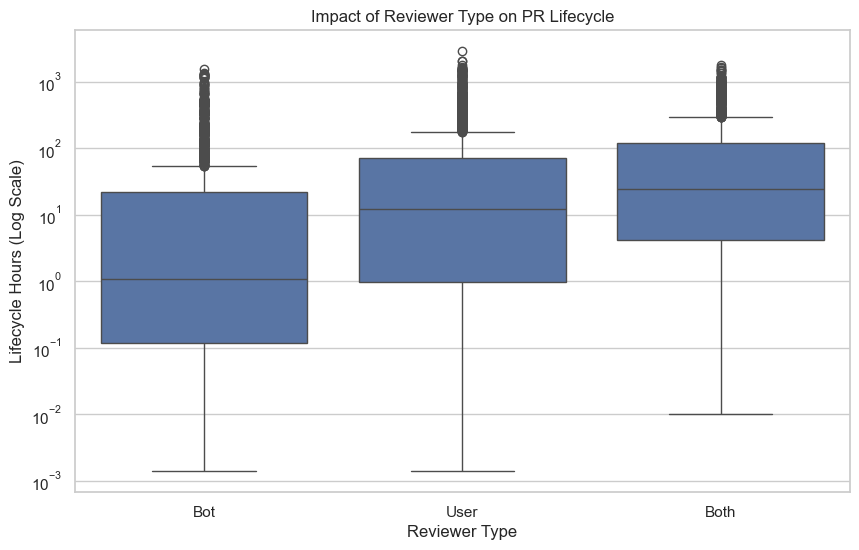

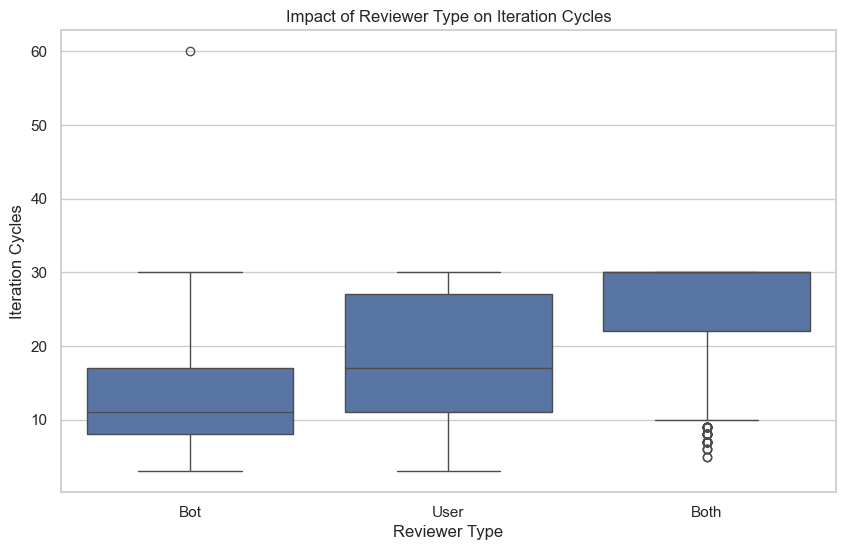

In [15]:
if 'final_df' in locals():
    print("Analyzing reviewer impact...")
    
    # Descriptive statistics
    stats = final_df.groupby("user_type_final")[["lifecycle_hours", "iteration_cycles"]].describe()
    print("\nDescriptive Statistics by Reviewer Type:")
    print(stats)
    # print(stats.to_markdown(index=False))
    
    # Visualization: Lifecycle Hours
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="user_type_final", y="lifecycle_hours", data=final_df, order=["Bot", "User", "Both"])
    plt.yscale("log")
    plt.ylabel("Lifecycle Hours (Log Scale)")
    plt.xlabel("Reviewer Type")
    plt.title("Impact of Reviewer Type on PR Lifecycle")
    plt.savefig("review_on effciency_hours_zaed.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    # Visualization: Iteration Cycles
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="user_type_final", y="iteration_cycles", data=final_df, order=["Bot", "User", "Both"])
    plt.ylabel("Iteration Cycles")
    plt.xlabel("Reviewer Type")
    plt.title("Impact of Reviewer Type on Iteration Cycles")
    plt.savefig("review_on effciency_iterations_zaed.png", dpi=300, bbox_inches="tight")
    plt.show()

#### Conclusion : Bot generated reviews lead to most efficient PRs - shortest lifecycle (in hours) and smallest number of iteration cycles. Combination of User and Bot reviews lead to least eefficiency.

#### However, it must be noted that number of data points of Bot generated reviews ONLY is fewer compared to others.

### combining with type of agent:

In [27]:
closed_prs = pr_df.loc[pr_df['state'] == 'closed', ['id',"agent"]]
closed_prs


,id,agent
0,3264933329,Claude_Code
1,3265118634,Claude_Code
2,3265640341,Claude_Code
3,3265709660,Claude_Code
16,3234102722,Claude_Code
...,...,...
33591,2857942945,Devin
33592,2857959763,Devin
33593,2858280902,Devin
33594,2858429985,Devin


In [32]:
merged_final_df = final_df.merge(
    closed_prs, 
    left_on="id", 
    right_on="id", 
    how="left"
)


merged_final_df

,id,state,lifecycle_hours,pr_id,iteration_cycles,user_type_final,agent
0,3265640341,closed,0.100833,3265640341,12,Both,Claude_Code
1,3265709660,closed,0.635556,3265709660,11,Bot,Claude_Code
2,3214555104,closed,47.635833,3214555104,30,User,Claude_Code
3,3214724259,closed,0.004444,3214724259,12,Bot,Claude_Code
4,3214782537,closed,203.482500,3214782537,30,Bot,Claude_Code
...,...,...,...,...,...,...,...
7311,3260345989,closed,29.747500,3260345989,17,Bot,Devin
7312,3260452571,closed,19.248056,3260452571,7,Both,Devin
7313,2857171695,closed,20.076389,2857171695,13,User,Devin
7314,2858429985,closed,15.211944,2858429985,18,User,Devin


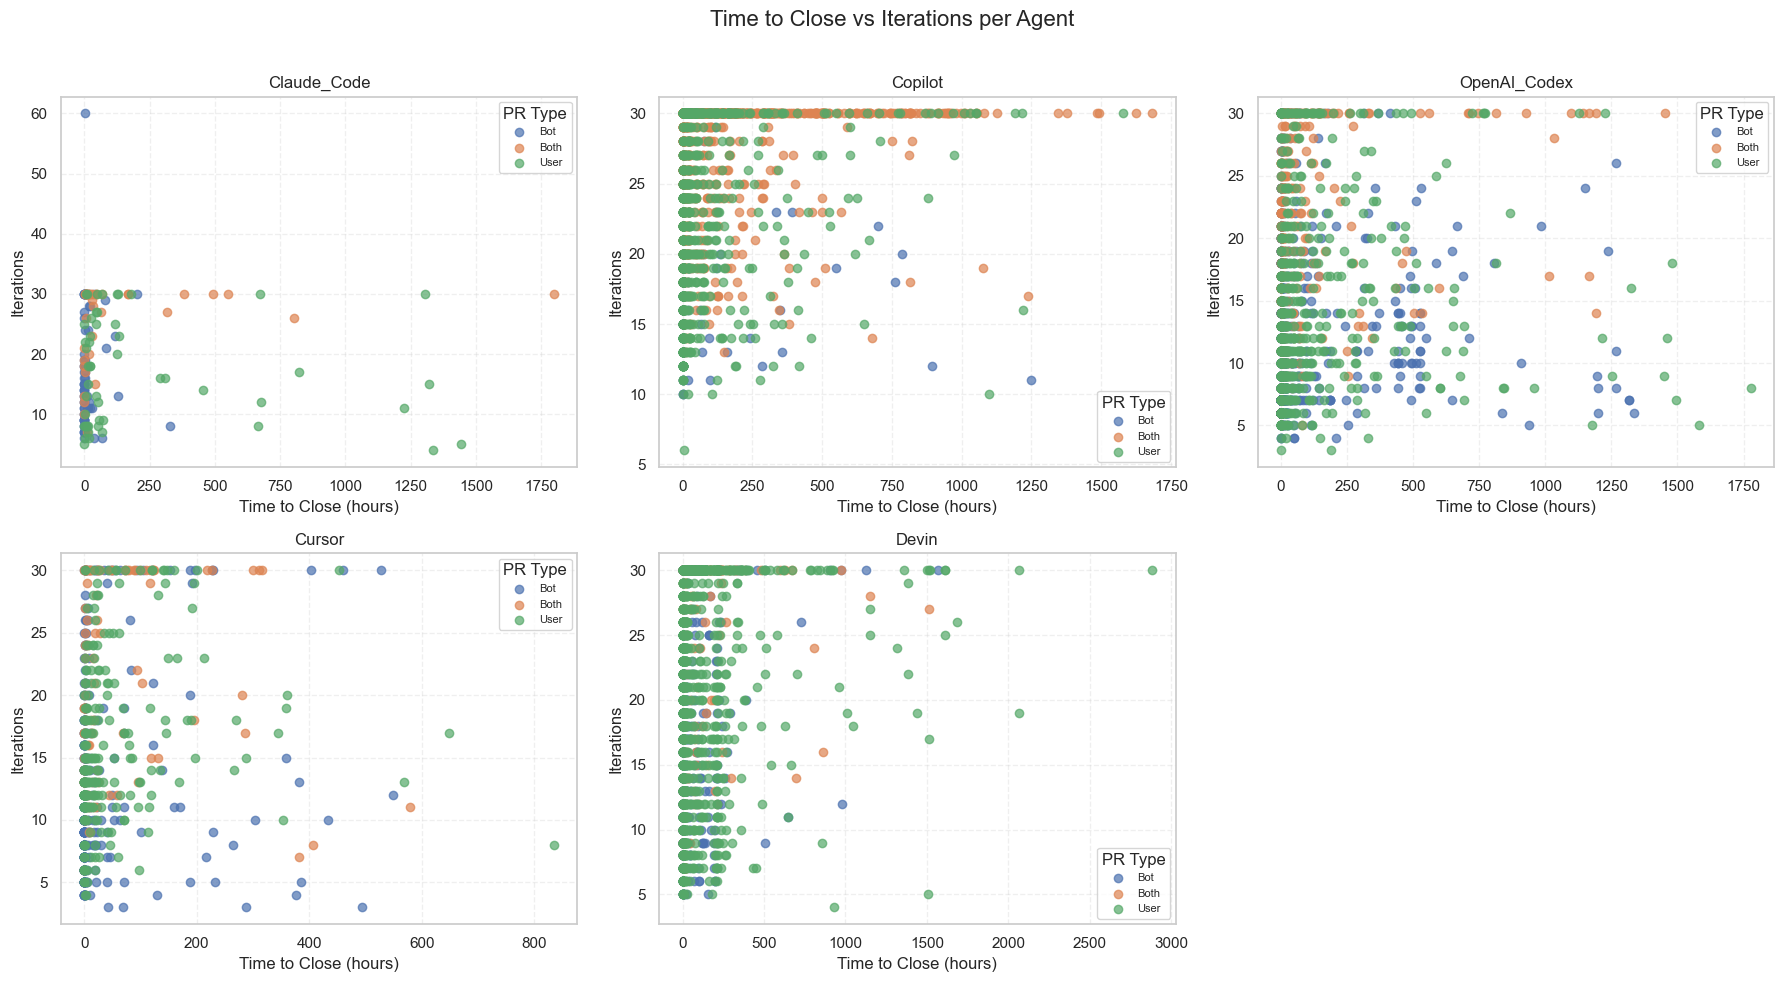

In [38]:
agents = merged_final_df["agent"].unique()
n_agents = len(agents)
cols = 3
rows = (n_agents + cols - 1) // cols  # Ceiling division

fig, axes = plt.subplots(rows, cols, figsize=(18, 10))
axes = axes.flatten()  # Make indexing easier

for i, agent in enumerate(agents):
    ax = axes[i]
    sub = merged_final_df[merged_final_df["agent"] == agent]
    for user_type, grp in sub.groupby("user_type_final"):
        ax.scatter(
            grp["lifecycle_hours"],
            grp["iteration_cycles"],
            alpha=0.7,
            label=user_type
        )

    ax.set_title(f"{agent}")
    ax.set_xlabel("Time to Close (hours)")
    ax.set_ylabel("Iterations")
    ax.grid(True, linestyle="--", alpha=0.3)
    ax.legend(title="PR Type", fontsize=8)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

fig.suptitle("Time to Close vs Iterations per Agent", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig("iterations_hours_bot_agent.png", dpi=300, bbox_inches="tight")
plt.show()
